# Pipeline practical session

Here we want to explore the use 

In this practical, we'll reproduce the Nolan neighbourhood analysis pipeline using their raw data by constructing a spatial analysis pipeline. To do so:
- Load in the TMA data using a dataframe
- Create domains for each TMA - make sure you add a way of identifying groups
- Run neighbourhood clustering over all samples
- Save the MuSpAn domains (as .muspan files or as a csv)

Don't forget to update the boundary for each core.


Information on the data:
- Every row corresponds to a single cell
- 'spots': a unique ID for each TMA
- 'groups': The patient group ID (1 OR 2)
- 'ClusterName': cell type following IF clustering
- 'X:X': the x-coordinate of the cell
- 'Y:Y': the y-coordinate of the cell

We are purposely providing the full dataset for this analysis to help the process of only extracting the relevent information needed for our spatial analysis.






In [1]:
import pandas as pd
import requests
import numpy as np
import muspan as ms
import seaborn as sns

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt 

nolan_tma_dataframe = pd.read_csv('/Users/joshuamoore/Dropbox/Ox_PostDoc/MuSpAn_paper/Existing_pipelines_data/Nolan_2020/Nolan_2020_data.csv')

In [2]:
nolan_tma_dataframe

,Unnamed: 0,CellID,ClusterID,EventID,File Name,Region,TMA_AB,TMA_12,Index in File,groups,...,CD68+Ki67+,CD68+PD-1+,CD8+ICOS+,CD8+Ki67+,CD8+PD-1+,Treg-ICOS+,Treg-Ki67+,Treg-PD-1+,neighborhood number final,neighborhood name
0,0,0,10668,0,reg001_A,reg001,A,1,0,1,...,0,0,0,0,0,0,0,0,9.0,Granulocyte enriched
1,1,1,10668,4,reg001_A,reg001,A,1,4,1,...,0,0,0,0,0,0,0,0,4.0,Macrophage enriched
2,2,2,10668,5,reg001_A,reg001,A,1,5,1,...,0,0,0,0,0,0,0,0,3.0,Immune-infiltrated stroma
3,3,3,10668,6,reg001_A,reg001,A,1,6,1,...,0,0,0,0,0,0,0,0,3.0,Immune-infiltrated stroma
4,4,4,10668,30,reg001_A,reg001,A,1,30,1,...,0,0,0,0,0,0,0,0,4.0,Macrophage enriched
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258380,258380,258380,10664,216709,reg057_B,reg057,B,2,1002,1,...,0,0,0,0,0,0,0,0,5.0,Follicle
258381,258381,258381,10664,222124,reg059_A,reg059,A,1,1272,2,...,0,0,0,0,0,0,0,0,3.0,Immune-infiltrated stroma
258382,258382,258382,10664,234850,reg062_A,reg062,A,1,735,2,...,0,0,0,0,0,0,0,0,1.0,T cell enriched
258383,258383,258383,10664,249806,reg067_A,reg067,A,1,174,1,...,0,0,0,0,0,0,0,0,6.0,Tumor boundary


In [3]:
spot_IDs=np.unique(nolan_tma_dataframe['spots'])

list_of_domains = []


for spot in spot_IDs:
    
    mask = nolan_tma_dataframe['spots']==spot
    
    
    points = nolan_tma_dataframe[mask][['X:X','Y:Y']]
    labels = nolan_tma_dataframe[mask]['ClusterName']
    this_group = nolan_tma_dataframe[mask]['groups'].values[0]   
    this_name=str(spot)+'_group_'+str(this_group)
    
    this_domain = ms.domain(this_name)
    this_domain.add_points(points.values,'cells')
    this_domain.add_labels('cell type',labels.values)
    this_domain.estimate_boundary('convex hull')
    
    
    list_of_domains.append(this_domain)
    

In [4]:
# Perform cluster neighbourhood analysis
neighbourhood_enrichment_matrix,label_categories,cluster_categories=ms.networks.cluster_neighbourhoods(list_of_domains,
                                   label_name='cell type',
                                   network_kwargs=dict(network_type='Delaunay',max_edge_distance=100),
                                   k_hops=3,
                                   transform_neighbourhood_composition='sqrt',
                                   neighbourhood_label_name='Neighbourhood ID',
                                   cluster_method='kmeans',
                                   cluster_parameters=dict(n_clusters=6),
                                   neighbourhood_enrichment_as='zscore')

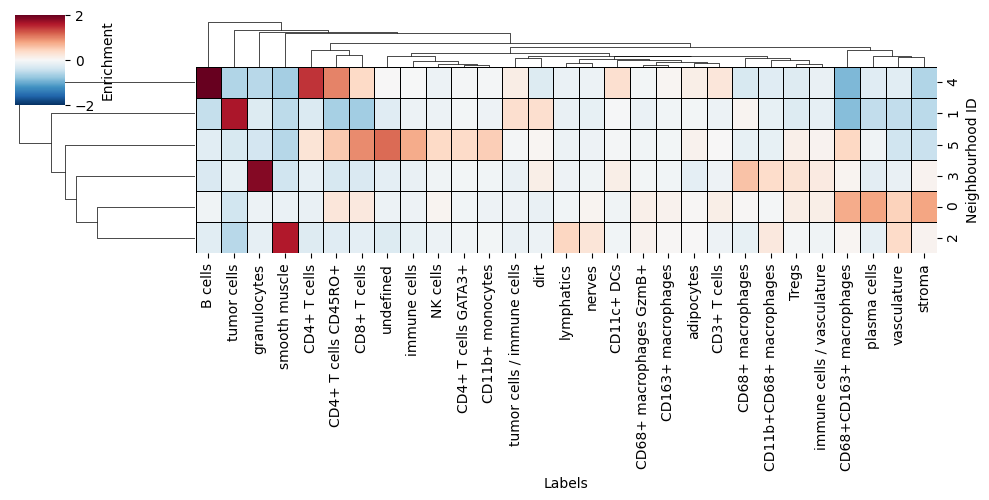

In [5]:
# this is simply visualising the neighbourhood enrichment matrix as a clustermap

# Create a DataFrame from the neighbourhood enrichment matrix
df_ME_id = pd.DataFrame(data=neighbourhood_enrichment_matrix, index=cluster_categories, columns=label_categories)
df_ME_id.index.name = 'Neighbourhood ID'
df_ME_id.columns.name = 'Labels'

# Visualize the neighbourhood enrichment matrix using a clustermap
sns.clustermap(
    df_ME_id,
    xticklabels=label_categories,
    yticklabels=cluster_categories,
    figsize=(10, 5),
    cmap='RdBu_r',
    col_cluster=True,
    row_cluster=True,
    square=True,
    linewidths=0.5,
    linecolor='black',
    cbar_kws=dict(use_gridspec=False, label='Enrichment', ticks=[-2, 0, 2]),
    vmin=-2,
    vmax=2,
    tree_kws={'linewidths': 0.5, 'color': 'black'}
)

In [6]:
composition_of_neigh_group_1=[]
composition_of_neigh_group_2=[]


for domain in list_of_domains:
    neigh_densities,these_labels = ms.summary_statistics.label_counts(domain,'Neighbourhood ID',normalised=True)
    
    these_densities = np.zeros(len(cluster_categories))
    for i, lab in enumerate(these_labels):
        these_densities[np.where(cluster_categories==lab)[0][0]] = neigh_densities[i]
        
    if domain.name.endswith('_group_1'):
        composition_of_neigh_group_1.append(these_densities)
    elif domain.name.endswith('_group_2'):
        composition_of_neigh_group_2.append(these_densities)
        
composition_of_neigh_group_1 = np.array(composition_of_neigh_group_1)
composition_of_neigh_group_2 = np.array(composition_of_neigh_group_2)

all_neigh_densities = np.vstack([composition_of_neigh_group_1,composition_of_neigh_group_2])    
group_indicator = np.array([1]*composition_of_neigh_group_1.shape[0]+[2]*composition_of_neigh_group_2.shape[0])

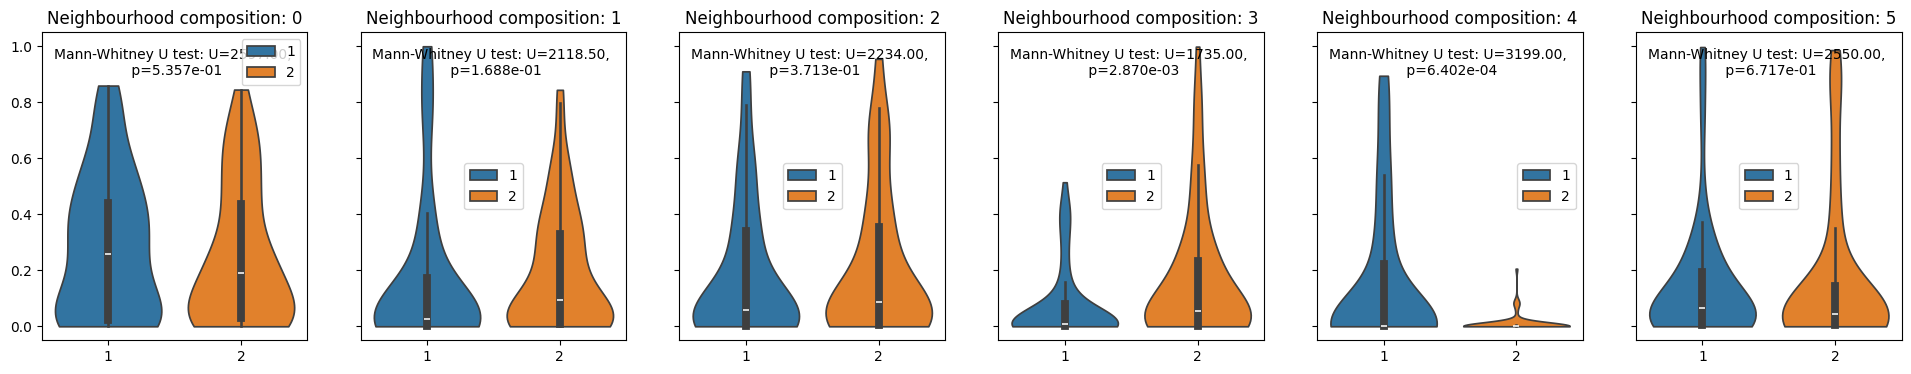

In [18]:
from scipy.stats import mannwhitneyu

fig,ax=plt.subplots(1,6,figsize=(24,4),sharey=True)

for i, cluster_label in enumerate(cluster_categories):
    
    cluster_index = np.where(cluster_categories==cluster_label)[0][0]
    
    
    sns.violinplot(x=group_indicator,y=all_neigh_densities[:,cluster_index],hue=group_indicator,palette='tab10',ax=ax[i],cut=0)
    
    
    # Perform Mann-Whitney U test between the two groups for the current cluster
    group_1_data = all_neigh_densities[group_indicator == 1, cluster_index]
    group_2_data = all_neigh_densities[group_indicator == 2, cluster_index]

    stat, p_value = mannwhitneyu(group_1_data, group_2_data)

    # Display the results
    ax[i].text(0.5, 0.95, f'Mann-Whitney U test: U={stat:.2f}, \n p={p_value:.3e}', 
        ha='center', va='top', transform=ax[i].transAxes)
    ax[i].set_title(f'Neighbourhood composition: {cluster_label}')  
    